#### Initialization

Imports

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from os import listdir
import seaborn as sns
import scipy
import math 
import random
from random import sample 
import gurobipy as gp
from matplotlib.lines import Line2D

Define files to read and use for optimization: data should be separated into individual files for each hour of the day which include columns with downward flexibility, upward flexibility, and energy flexibility, with one "measurement" per day. The files used are named as "alt_hourX.csv", where "X" denotes the hour of the day and will be used later in the code for correctly placing results in dataframes. The files can be called anything, as long as it ends with "X" and does not contain any other numbers.

In [124]:
def find_csv_filenames(path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [125]:
directory = os.getcwd()
filenames = find_csv_filenames(directory)
hours_data = [l for l in filenames if l.startswith('alt_hour')]

Define variables

In [126]:
def sample_size(eps, delta, p):
    return math.ceil((2/eps)*np.log(1/delta) + 2*p + (2*p/eps)*np.log(2/eps))

In [127]:
s = 10                          # Number of runs
t = 24                          # Number of hours in day

eps = 0.1                       # P90 requirement from Energinet
delta = 0.01                    # Following Eq. (13), having a 99% chance the data represents the underlying distribution
p = 2                           # Number of parameters for estimation of Weibull distribution
n = sample_size(eps, delta, p)  # Sample size following Eq. (13)

#### Sample based optimization method following Section VI

In [128]:
j = 3   # Number of columns for results (opt sol, b_up, and b_down)
optresults_SAA = np.zeros((s, j, t)) # For storing results

In [129]:
# Run optimization for all hours of the day s times
for data in hours_data:
    for i in range(s):
        random.seed(i)
        list1 = range(0, 365) 
        samples = sample(list1, n)
        not_samples = list(set(list1) - set(samples))

        df = pd.read_csv(directory + "\\" + data)
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        Mu, Md, Me = np.max(df['upward']), np.max(df['downward']), np.max(df['energy'])

        # Create a new model
        m = gp.Model()

        # Create variables
        b_up = m.addVar(vtype='C', name="b_up")
        b_down = m.addVar(vtype='C', name="b_down")
        z = m.addVars(n, vtype='B', name="z")

        # Set objective function
        m.setObjective(b_up + b_down, gp.GRB.MAXIMIZE) # Obj fun Eq. (12a)

        # Add constraints
        m.addConstrs(0.2*b_down + b_up - df['upward'][samples[j]] <= z[j]*Mu for j in range(0, n))    # Cons. (12b)
        m.addConstrs(b_down - df['downward'][samples[j]] <= z[j]*Md for j in range(0, n))             # Cons. (12c)
        m.addConstrs(b_down - df['energy'][samples[j]] <= z[j]*Me for j in range(0, n))               # Cons. (12d)
        m.addConstr(z.sum() == int(n*eps))                                                            # Cons. (12e)

        # Solve it!
        m.optimize()

        # Get results
        optresults_SAA[i, 0, k - 1], optresults_SAA[i, 1, k - 1], optresults_SAA[i, 2, k - 1] = m.objVal, b_up.X, b_down.X


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 649 rows, 218 columns and 1728 nonzeros
Model fingerprint: 0xc967d3de
Variable types: 2 continuous, 216 integer (216 binary)
Coefficient statistics:
  Matrix range     [2e-01, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+01, 5e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 216 rows and 0 columns
Presolve time: 0.00s
Presolved: 433 rows, 218 columns, 1296 nonzeros
Variable types: 2 continuous, 216 integer (216 binary)

Root relaxation: objective 2.410871e+03, 199 iterations, 0.00 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

#### Analytical reformulation method following Section V

Fitting distributions

In [130]:
j = 7   # Number of columns for distribution fitting (hour, kappa (Weibull), gamma (Weibull), nll, D (KS test), p (KS test), quantile value (90%))
downfit = np.zeros((s, j, t))
upfit = np.zeros((s, j, t))
energyfit = np.zeros((s, j, t))

In [159]:
'''
Function for fitting a two-parameter Weibull distribution to the lower tail of data,
using the negative log-likelihood function

Input:
    df      - dataframe containing data to which the distribution should be fit
    g       - potential gamma-values of the Weibull distribution
    n       - number of samples from df which should be used

Output:
    estimated gamma- and kappa-values, and the log-likelihood at those values.
'''
def Weibull_fitting(df, g, n):
    m = len(df)
    nll = np.zeros((len(g)))
    j = 0
    for i in g:
        nll[j] = m*np.log(n) - m*np.log(np.sum(df**i)) + m*np.log(i) + (i - 1)*np.sum(np.log(df)) - m
        j = j + 1
    ind = np.argmax(nll)
    return m/np.sum(df**g[ind]), g[ind], -nll[ind]

In [132]:
'''
Function for doing a Kolmogorov-Smirnov test on the fit of a Weibull distribution to data

Input:
    df                  - dataframe containing data which has been used for the fitting
    kappa               - fitted kappa value
    gamma               - fitted gamma value

Output:
    kstest.statistic    - D-value from KS-test
    kstest.pvalue       - p-value from KS-test
'''
def KStest(df, kappa, gamma):
    tmp1 = scipy.stats.ecdf(df)
    tmp1 = tmp1.cdf.probabilities
    tmp2 = 1 - np.exp(-kappa*df**gamma)
    kstest = scipy.stats.kstest(sorted(tmp1), sorted(tmp2))
    return kstest.statistic, kstest.pvalue

In [157]:
'''
Function for initialising the fitting a two-parameter Weibull distribution to the 
lower tail of data, which also performs a KS-test after the fit.

Input:
    df      - dataframe containing data to which the distribution should be fit
    string  - name of column
    df_fits - dataframe where results should be stored
    k       - hour of results
    g       - potential gamma-values of the Weibull distribution
    n       - number of samples from df which should be used

Output:
    df_fits - dataframe with stored results
'''
def fitting_procedure(df, string, df_fits, k, g, n):
    df_fits[0] = k
    df[string + '_tmp'] = df[string]
    df[string] = -df[string + '_tmp']
    df_fits[6] = np.quantile(df[string], 0.9)
    df_quantile = df[string][df[string] > df_fits[6]]
    df_quantile = df_quantile - df_fits[6]

    # Fit Weibull distribution
    df_fits[1], df_fits[2], df_fits[3] = Weibull_fitting(df_quantile, g, n)

    # Perform KS test
    df_fits[4], df_fits[5] = KStest(df_quantile, df_fits[1], df_fits[2])

    return df_fits

In [ ]:
# Potential gamma-values
g = np.linspace(0.01, 3, num=200)

# Run distribution fitting for all hours of the day s times (s splits)
for i in range(s):
    random.seed(i)
    list1 = range(0, 365) 
    samples = sample(list1, n)
    not_samples = list(set(list1) - set(samples))
    for data in hours_data:
        df = pd.read_csv(directory + "\\" + data)
        df = df.iloc[samples]
        k = int(''.join(filter(lambda j: j.isdigit(), data)))

        downfit[i, :, k - 1] = fitting_procedure(df, 'downward', downfit[i, :, k - 1], k, g, n)
        upfit[i, :, k - 1] = fitting_procedure(df, 'upward', upfit[i, :, k - 1], k, g, n)
        energyfit[i, :, k - 1] = fitting_procedure(df, 'energy', downfit[i, :, k - 1], k, g, n)

In [162]:
def Weibull_constraint(kappa, gamma, eps):
    return (-(1/kappa)*np.log(eps))**(1/gamma)

In [163]:
j = 3   # Number of columns for optimization results
optresults_anaform = np.zeros((s, j, t))

In [164]:
# Run optimization for all hours of the day s times
for i in range(s):
    for data in hours_data:
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        
        # Create a new model
        m = gp.Model()

        # Create variables
        b_up = m.addVar(vtype='C', name="b_up")
        b_down = m.addVar(vtype='C', name="b_down")

        # Set objective function
        m.setObjective(b_up + b_down, gp.GRB.MAXIMIZE) # Eq. (11a)

        # Add constraints
        m.addConstr(0.2*b_down + b_up <= -Weibull_constraint(upfit[i, 1, k - 1], upfit[i, 2, k - 1], 1/3) - upfit[i, 6, k - 1])   # Cons. (11b)
        m.addConstr(b_down <= -Weibull_constraint(downfit[i, 1, k - 1], downfit[i, 2, k - 1], 1/3) - downfit[i, 6, k - 1])        # Cons. (11c)
        m.addConstr(b_down <= -Weibull_constraint(energyfit[i, 1, k - 1], energyfit[i, 2, k - 1], 1/3) - energyfit[i, 6, k - 1])  # Cons. (11d)

        # Solve it!
        m.optimize()

        optresults_anaform[i, 0, k - 1], optresults_anaform[i, 1, k - 1], optresults_anaform[i, 2, k - 1] = m.objVal, b_up.X, b_down.X
        

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3 rows, 2 columns and 4 nonzeros
Model fingerprint: 0x0b9a5153
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+02, 2e+03]
Presolve removed 3 rows and 2 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5298384e+03   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.529838351e+03
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-1365U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cor

#### Constraint violation check

In [165]:
j = 4

# Overbidding stats
overbid_SAA = np.zeros((s, j, t))   # Number of violations
overbid_p_SAA = np.zeros((s, j, t)) # Percentage of all samples
overbid_ana = np.zeros((s, j, t))   # Number of violations
overbid_p_ana = np.zeros((s, j, t)) # Percentage of all samples

In [166]:
def OOS_count(df_OOS, not_samples, optresults, overbid, overbid_p):
    for j in range(len(df_OOS)):
            cons1 = optresults[1] + 0.2*optresults[2] - df_OOS['upward'][not_samples[j]] > 0
            cons2 = optresults[2] - df_OOS['downward'][not_samples[j]] > 0
            cons3 = optresults[2] - df_OOS['energy'][not_samples[j]] > 0
            if cons1: overbid[0] = overbid[0] + 1
            if cons2: overbid[1] = overbid[1] + 1
            if cons3: overbid[2] = overbid[2] + 1
            if (cons1 or cons2 or cons3):
                overbid[3] = overbid[3] + 1

    for j in range(4):
        overbid_p[j] = overbid[j]/(365 - n) * 100
    
    return overbid, overbid_p

In [167]:
for data in hours_data:
    for i in range(s):
        random.seed(i)
        list1 = range(0,365) 
        samples = sample(list1, n)
        not_samples = list(set(list1) - set(samples))
        df = pd.read_csv(directory + "\\" + data)
        k = int(''.join(filter(lambda j: j.isdigit(), data)))
        df_OOS = df.iloc[not_samples]

        overbid_ana[i, :, k - 1], overbid_p_ana[i, :, k - 1] = OOS_count(df_OOS, not_samples, optresults_anaform[i, :, k - 1], overbid_ana[i, :, k - 1], overbid_p_ana[i, :, k - 1])
        overbid_SAA[i, :, k - 1], overbid_p_SAA[i, :, k - 1] = OOS_count(df_OOS, not_samples, optresults_SAA[i, :, k - 1], overbid_SAA[i, :, k - 1], overbid_p_SAA[i, :, k - 1])

#### Plot results

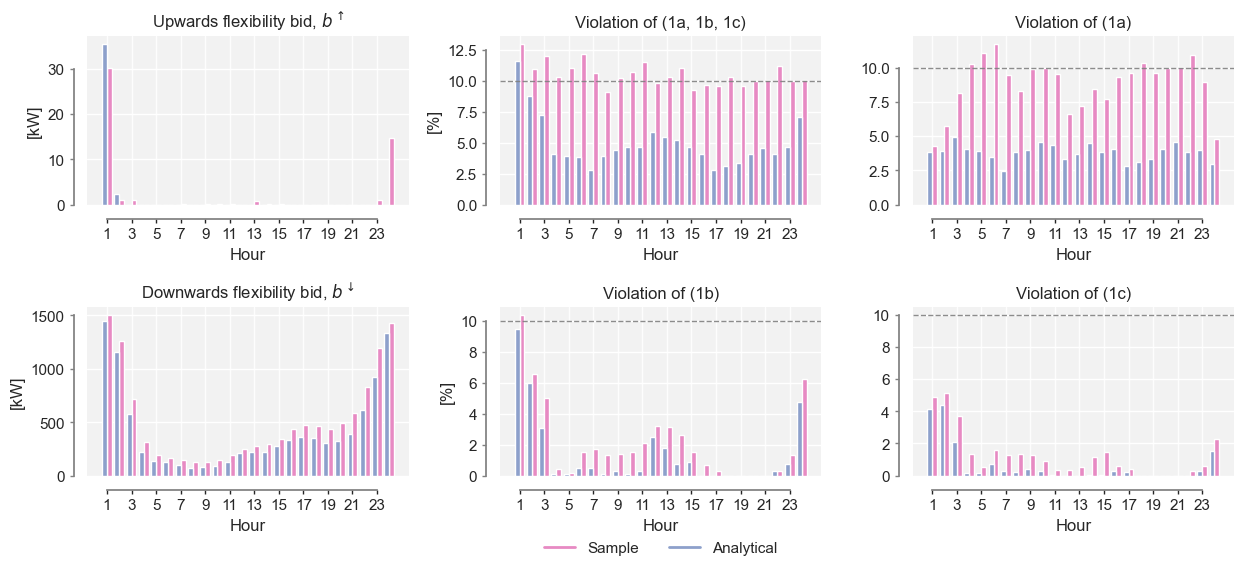

In [168]:
custom_lines = [Line2D([0], [0], color='#e78ac3', lw=2, label='Sample'),
                Line2D([0], [0], color='#8da0cb', lw=2, label='Analytical')]

fig, axs = plt.subplots(2, 3, figsize=(0.7*18, 0.7*8))
sns.set_theme(context="paper", style="ticks")
sns.set_style({'axes.linewidth': 0.5})
sns.set(rc={'axes.facecolor':'#f2f2f2', 'figure.facecolor':'white'})

axs[0,0].set_ylabel('[kW]')
axs[0,0].set_title(r'Upwards flexibility bid, $b^\uparrow$')
axs[0,0].bar(range(0,24), optresults_SAA[:, 1, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[0,0].bar(range(0,24), optresults_anaform[:, 1, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')

axs[1,0].set_ylabel('[kW]')
axs[1,0].set_title(r'Downwards flexibility bid, $b^\downarrow$')
axs[1,0].bar(range(0,24), optresults_SAA[:, 2, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[1,0].bar(range(0,24), optresults_anaform[:, 2, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')

axs[0,1].set_title('Violation of (1a, 1b, 1c)')
axs[0,1].set_ylabel('[%]')
axs[0,1].bar(range(0,24), overbid_p_SAA[:, 3, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[0,1].bar(range(0,24), overbid_p_ana[:, 3, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[0,1].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[1,1].set_title('Violation of (1b)')
axs[1,1].set_ylabel('[%]')
axs[1,1].bar(range(0,24), overbid_p_SAA[:, 1, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[1,1].bar(range(0,24), overbid_p_ana[:, 1, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[1,1].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[0,2].set_title('Violation of (1a)')
axs[0,2].bar(range(0,24), overbid_p_SAA[:, 0, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[0,2].bar(range(0,24), overbid_p_ana[:, 0, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[0,2].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[1,2].set_title('Violation of (1c)')
axs[1,2].bar(range(0,24), overbid_p_SAA[:, 2, :].mean(axis=0), color='#e78ac3', width = 0.4, align='edge')
axs[1,2].bar(range(0,24), overbid_p_ana[:, 2, :].mean(axis=0), color='#8da0cb', width = -0.4, align='edge')
axs[1,2].axhline(y = 10, color = 'grey', linestyle='dashed', linewidth=1, alpha=0.9)

axs[0,0].tick_params(axis='y')
axs[0,0].grid(True)

for i in range(2):
    for j in range(3):
        axs[i,j].set_xlabel('Hour')
        axs[i,j].set_xticks(range(0, 24, 2), minor=False)
        axs[i,j].xaxis.grid(True, which='major', alpha=0.9)
        ticks = list(range(1, 25, 2))
        axs[i,j].set_xticklabels(ticks)

plt.rcParams['xtick.major.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True

plt.rcParams['ytick.major.size'] = 3
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.left'] = True

for i in range(2):
    for j in range(3):
        for spine in axs[i,j].spines.values():
            spine.set_edgecolor('grey')
        axs[i,j].yaxis.set_tick_params(width=1, color='grey')
        sns.despine(ax=axs[i,j], offset=10, trim=True, right=True, bottom=False, left=False, top=True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

axs[1,1].legend(handles=custom_lines, fancybox=True, facecolor='white', framealpha=0, bbox_to_anchor=(0.5, -0.55), loc='lower center', ncol = 6) 
